### 0. Imports

In [30]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# append parent folder to path
import sys 
sys.path.append("..")

# import database connection support functions
from src.support.data_load_support import connect_to_database, connect_and_query, alter_update_query
from src.support.data_visualization_support import plot_bar_labels

# import env variables
import os
from dotenv import load_dotenv
load_dotenv()
database_credentials = {
    "username": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}


# 1. Introduction to this notebook

The purpose of this notebook is to analyse the information from the created database of scraped data. As an exercise, minimum pandas is to be used, making transformations almost exclusively from querying the database.

The functions used as a support for this notebook can be found in `src/support/data_visualization_support.py`.

# 2. Analysis

The scraped data focuses on the historical price of basic foods in Spain: Olive oil, milk and suflower oil.

The goal of this analysis is, among other things, to find what the spread of prices for the same products is among different supermaket chains, which are the least and most expensive variations or brands, where to find them, and what is their price evolution.

## 2.1 Create latest price column in supermarket_products

As the most important price is the current price, a column will be added to the intermediate table between supermarket and products, to make queries easier.

In [31]:
# create new column latest price in supermarkets_products
alter_query = """
ALTER TABLE supermarkets_products 
ADD COLUMN latest_price NUMERIC;
"""

alter_update_query("comparativa_supermercados",database_credentials,alter_query)

# fill in new column with latest price values
update_query = """
WITH most_recent_date AS (
			SELECT supermarket_product_id , price_amount,date, MAX(date) OVER(PARTITION BY supermarket_product_id) AS most_recent
			FROM prices p),

latest_price AS (SELECT supermarket_product_id, price_amount, date
FROM most_recent_date
WHERE date = most_recent)

UPDATE supermarkets_products s
SET latest_price = l.price_amount
FROM latest_price l
WHERE l.supermarket_product_id = s.supermarket_product_id;
"""

alter_update_query("comparativa_supermercados",database_credentials, update_query)

What are the main category price comparison between products?

## 2.2 Analyse product price spread accross supermarkets and categories

Let's query the database and plot the 

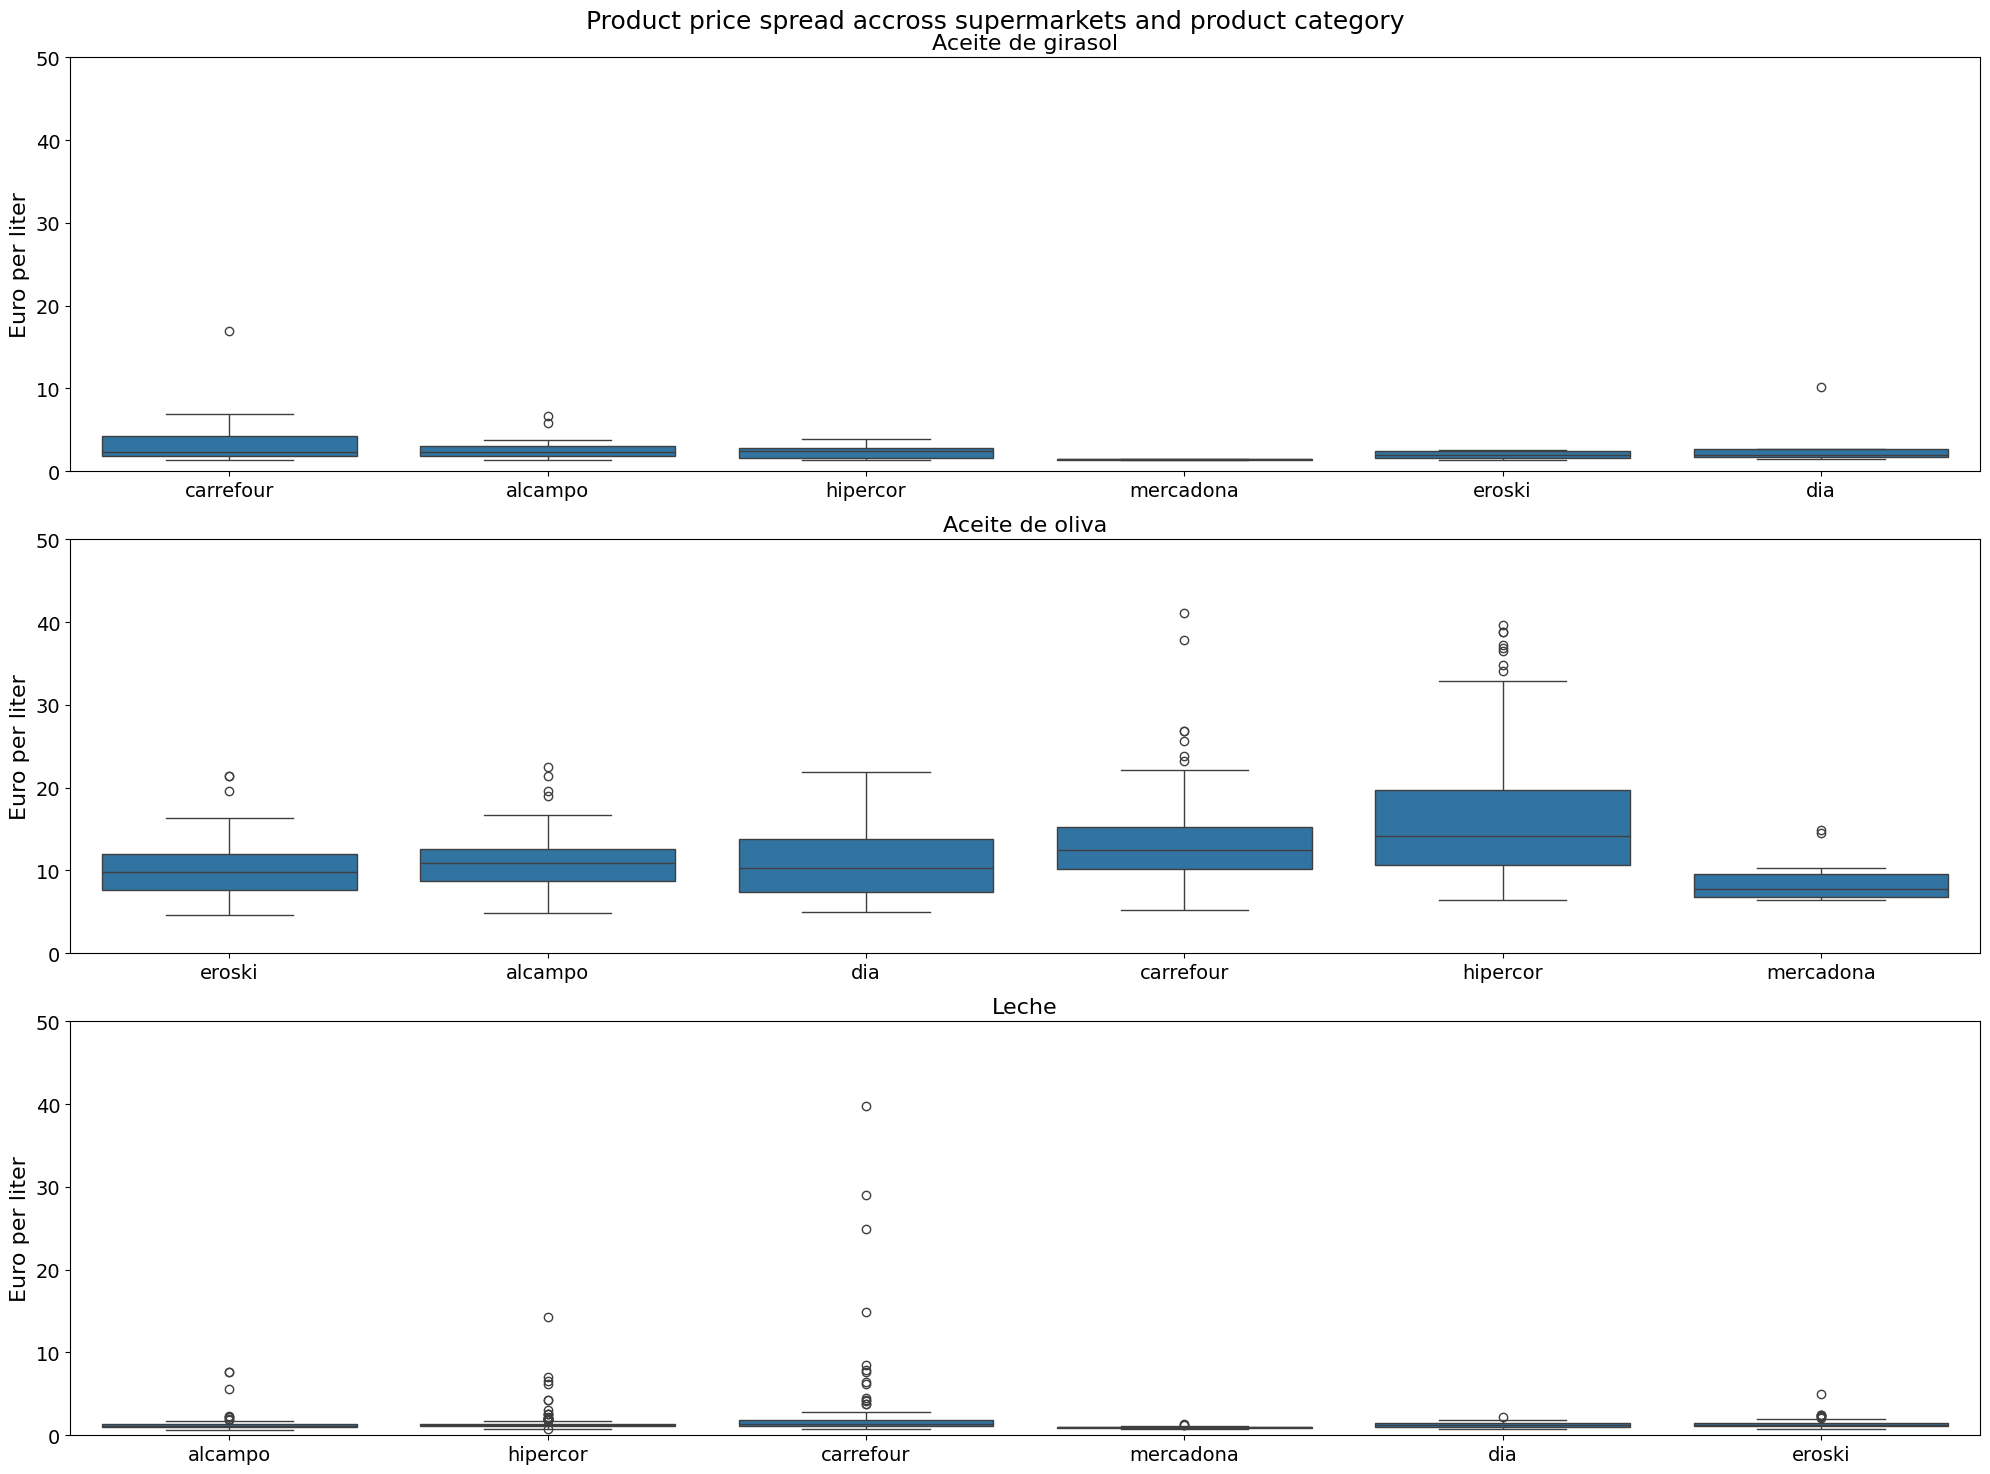

In [202]:
fig, axes = plt.subplots(3,1,figsize=(20,15))

axes_flat = axes.flat

plt.suptitle("Product price spread accross supermarkets and product category", fontsize=18)

for ax, category in zip(axes_flat, ["'aceite_de_girasol'","'aceite_de_oliva'","'leche'"]):

	query = f"""
	SELECT s2.supermarket_name, category_name, subcategory_name, CONCAT(category_name, ' ', subcategory_name) AS subcategory_full, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
	FROM products p 
	INNER JOIN subcategories s 
		ON p.subcategory_id =s.subcategory_id 
	INNER JOIN categories c 
		ON s.category_id = c.category_id 
	INNER JOIN supermarkets_products sp 
		ON p.product_id = sp.product_id
	INNER JOIN supermarkets s2
		ON sp.supermarket_id = s2.supermarket_id 
	INNER JOIN brands b
		ON b.brand_id = p.brand_id 
	WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
	AND units IS NOT NULL 
	AND units != 'g'
	AND s.subcategory_name NOT LIKE '%otras%'
	AND subcategory_name != 'cabra'
	AND category_name = {category}
	ORDER BY euro_per_liter;
	"""

	spread_analysis = connect_and_query("comparativa_supermercados", database_credentials, query)

	category_formatted = category.replace("\'","").replace("_"," ").capitalize()
	ax.set_title(category_formatted, fontsize=16)
	sns.boxplot(
		data=spread_analysis,
		x="supermarket_name",
		y="euro_per_liter",
		ax=ax
	)

	ax.set_ylim(0,50)
	ax.set_ylabel("Euro per liter", fontsize=16)
	ax.tick_params(axis="both",labelsize=14)
	ax.set_xlabel(None)


plt.tight_layout()
plt.show()

query = """
SELECT supermarket_name, category_name, ROUND(AVG(sp.latest_price / (p.quantity * p.volume_weight)),2) AS avg,
    ROUND(MIN(sp.latest_price / (p.quantity * p.volume_weight)),2) AS min,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY sp.latest_price / (p.quantity * p.volume_weight)) AS percentile_25,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY sp.latest_price / (p.quantity * p.volume_weight)) AS median,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY sp.latest_price / (p.quantity * p.volume_weight)) AS percentile_75,
    ROUND(MAX(sp.latest_price / (p.quantity * p.volume_weight)),2) AS max,
	ROUND((MAX(sp.latest_price / (p.quantity * p.volume_weight)) - MIN(sp.latest_price / (p.quantity * p.volume_weight))) / NULLIF(AVG(sp.latest_price / (p.quantity * p.volume_weight)), 0),2) AS spread_coef
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND subcategory_name != 'cabra'
GROUP BY category_name, supermarket_name
ORDER BY category_name, supermarket_name;
"""
spread_analysis = connect_and_query("comparativa_supermercados", database_credentials, query)

From the boxplots, starting by sunflower oil, it can be observed that spreads are moderate. Mercadona keeps a very low variability of their sunflower prices, while carrefour has a bigger IQR and also very high outliers. Other chains keep their price IQR between around 1.65 and more than 2.75.

Continuing with olive oil, price is higher but overall spread is lower. Again, spread is lowest for mercadona and highest for carrefour, as confirmed by the descriptive summary below. The major culprit of high spread in the case of olive oil are the outliers in price.

Finally, the IQR of milk is the lowest, although it is as affected by outliers as sunflower oil for instance. Once again, mercadona shows the lowest spread, being carrefour and hipercor the ones showing a higher one.

Quite probably, one factor for extremely high prices is the conversion to price per liter, where most possibly, a very expensive product with low quantity is skyrocketing prices.

The table below summarizes the boxplots numerically.

In [201]:
display(spread_analysis)

,supermarket_name,category_name,avg,min,percentile_25,median,percentile_75,max,spread_coef
0,alcampo,aceite_de_girasol,2.81,1.38,1.820000,2.340000,3.100000,6.67,1.88
1,carrefour,aceite_de_girasol,52.88,1.35,1.830000,2.350000,4.298333,740.80,13.98
2,dia,aceite_de_girasol,3.21,1.43,1.704000,1.996000,2.700000,10.20,2.74
3,eroski,aceite_de_girasol,2.02,1.38,1.630000,1.940000,2.426000,2.59,0.60
4,hipercor,aceite_de_girasol,2.37,1.38,1.555000,2.440000,2.805000,3.90,1.06
5,mercadona,aceite_de_girasol,1.43,1.38,1.406500,1.431000,1.455500,1.48,0.07
6,alcampo,aceite_de_oliva,12.16,4.85,8.730000,10.878000,12.620000,166.00,13.25
7,carrefour,aceite_de_oliva,16.31,5.19,10.150000,12.490000,15.295000,291.00,17.52
8,dia,aceite_de_oliva,10.77,4.99,7.370000,10.333333,13.800000,21.85,1.57
9,eroski,aceite_de_oliva,12.41,4.66,7.687500,9.849000,12.040000,150.00,11.71


## 2.2 Zoom into price distribution accross supermarkets

To get a clearer image of what prices each supermarket offers let's plot their average product distribution, first on total average, and then per category.



For this query, we will filter out products that have units, which unit is not grams and that have a defined subcategory other than 'others'.

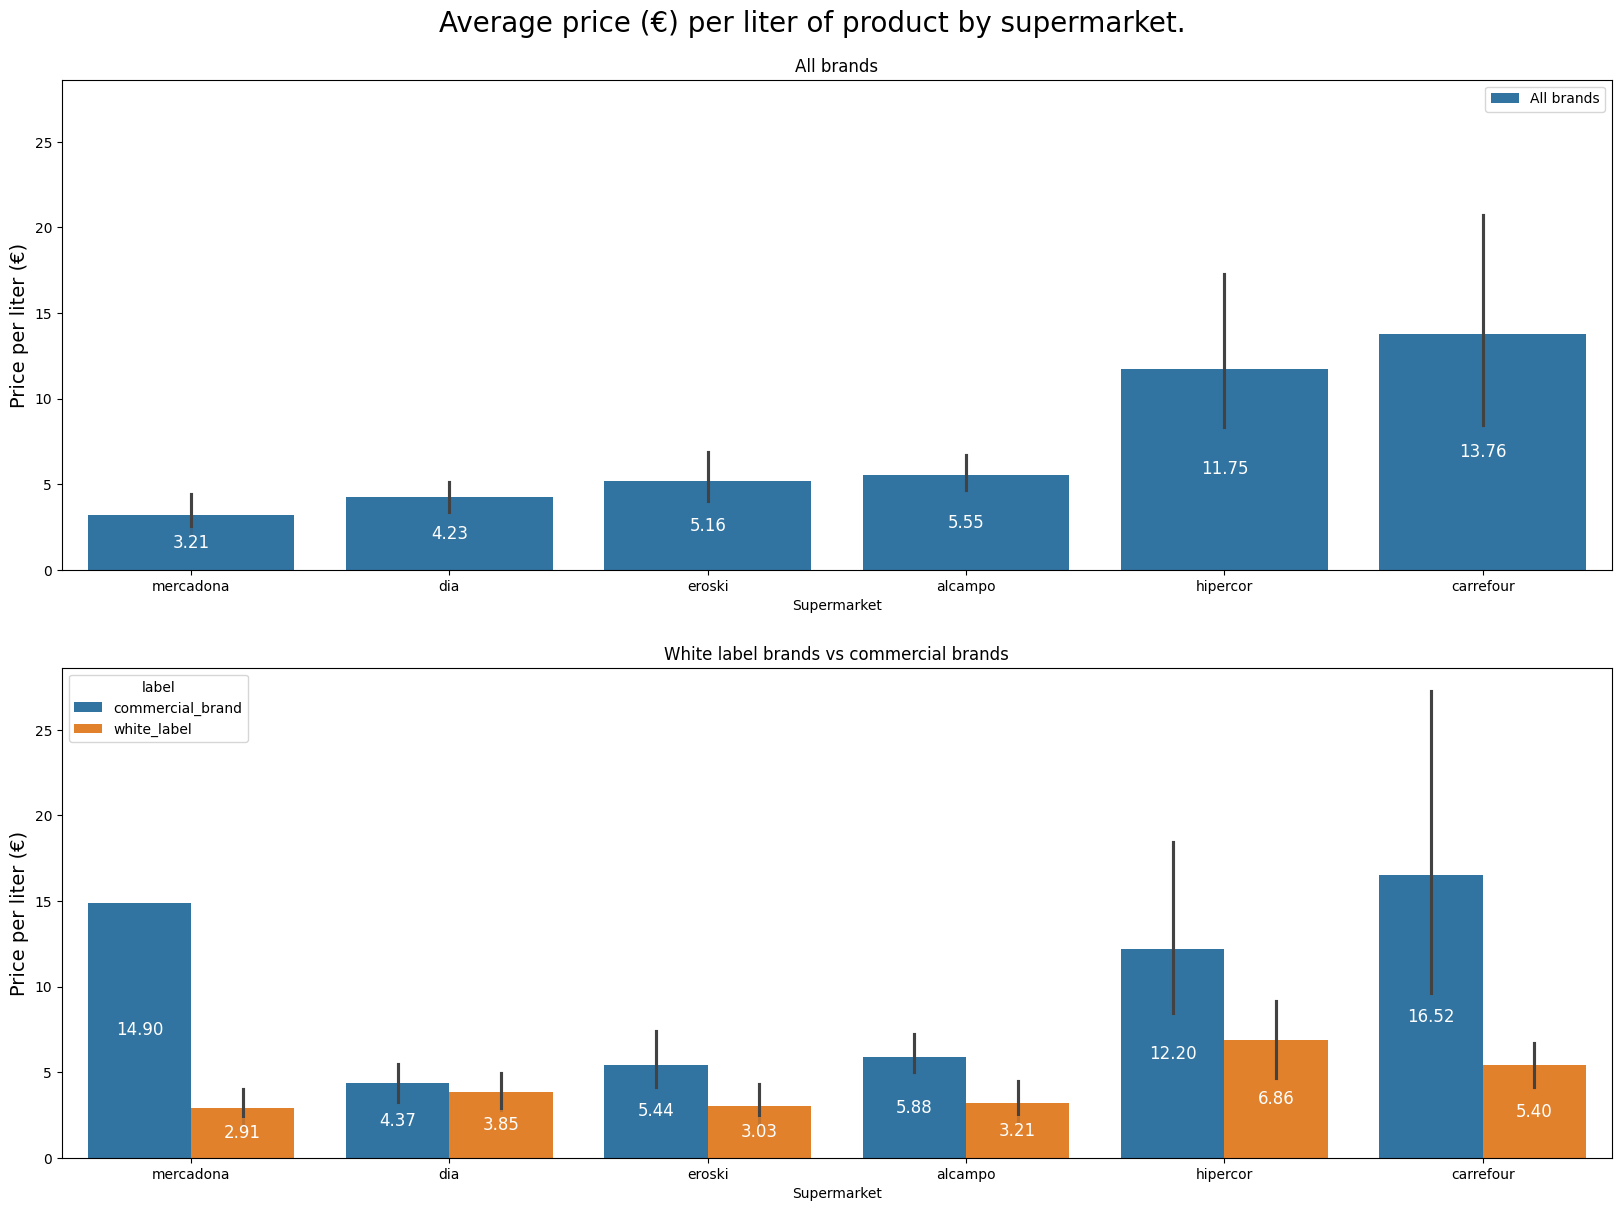

In [37]:
# Calculate mean price per supermarket, use as a sorting function for the plot
query = """
SELECT s2.supermarket_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, COUNT(*) n_products
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
GROUP BY s2.supermarket_name,  p.units
ORDER BY euro_per_liter;
"""
supermarket_average = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")


# Query prices
query1 = """
SELECT s2.supermarket_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
ORDER BY euro_per_liter;
"""
price_per_category_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query1, columns="query")

# Query prices differentiating all brands from white label
query2 = """
SELECT s2.supermarket_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter, 
        CASE WHEN b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles') THEN 'white_label'
        ELSE 'commercial_brand' END as label
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
ORDER BY euro_per_liter;
"""

price_per_category_white_label_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query2, columns="query")

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 14), sharey=True) 

plt.suptitle("Average price (€) per liter of product by supermarket.", fontsize=20, y=0.93)

##First plot
sns.barplot(data=price_per_category_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             ax=ax1,
             order=supermarket_average["supermarket_name"],
             estimator="mean",
             label="All brands")

# ax title
ax1.set_title("All brands")

# adding data labels
plot_bar_labels(ax1)


ax1.set_ylabel("Price per liter (€)", fontsize=14)
ax1.set_xlabel("Supermarket")


## second plot
sns.barplot(data=price_per_category_white_label_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             hue= "label",
             ax=ax2,
             order=supermarket_average["supermarket_name"],
             estimator="mean")

# ax title
ax2.set_title("White label brands vs commercial brands")

# adding data labels
plot_bar_labels(ax2)


ax2.set_ylabel("Price per liter (€)", fontsize=14)
ax2.set_xlabel("Supermarket")


plt.show()

Here we can see that all supermarket chains see their average price per liter of product reduced when focusing on their on white label brand. The most expensive chains see their prices reduced the most, although their prices stil stay more expensive. The fat that their average price is so much reduced indicates that they focus on high-end products, but also the fact that their outliers lie on the 'all brands' category of brand, and not their white labels. Nevertheless, their average white label price is still high, which provides information about their brand status and the quality brand they promote.

There is one very high bar plotted for 'all brands' on Mercadona. If looking closely, one can see that it has no errorbar, meaning that it's just one occurrence and it is probably some brand or miscalculated quantity. That is to say that, contrary to other brands, Mercadona focuses almost exclusively on developing it's own brand, 'Hacendado', which is the most affordable.

Now, let's take a look at the product price distribution by supermarket and category:

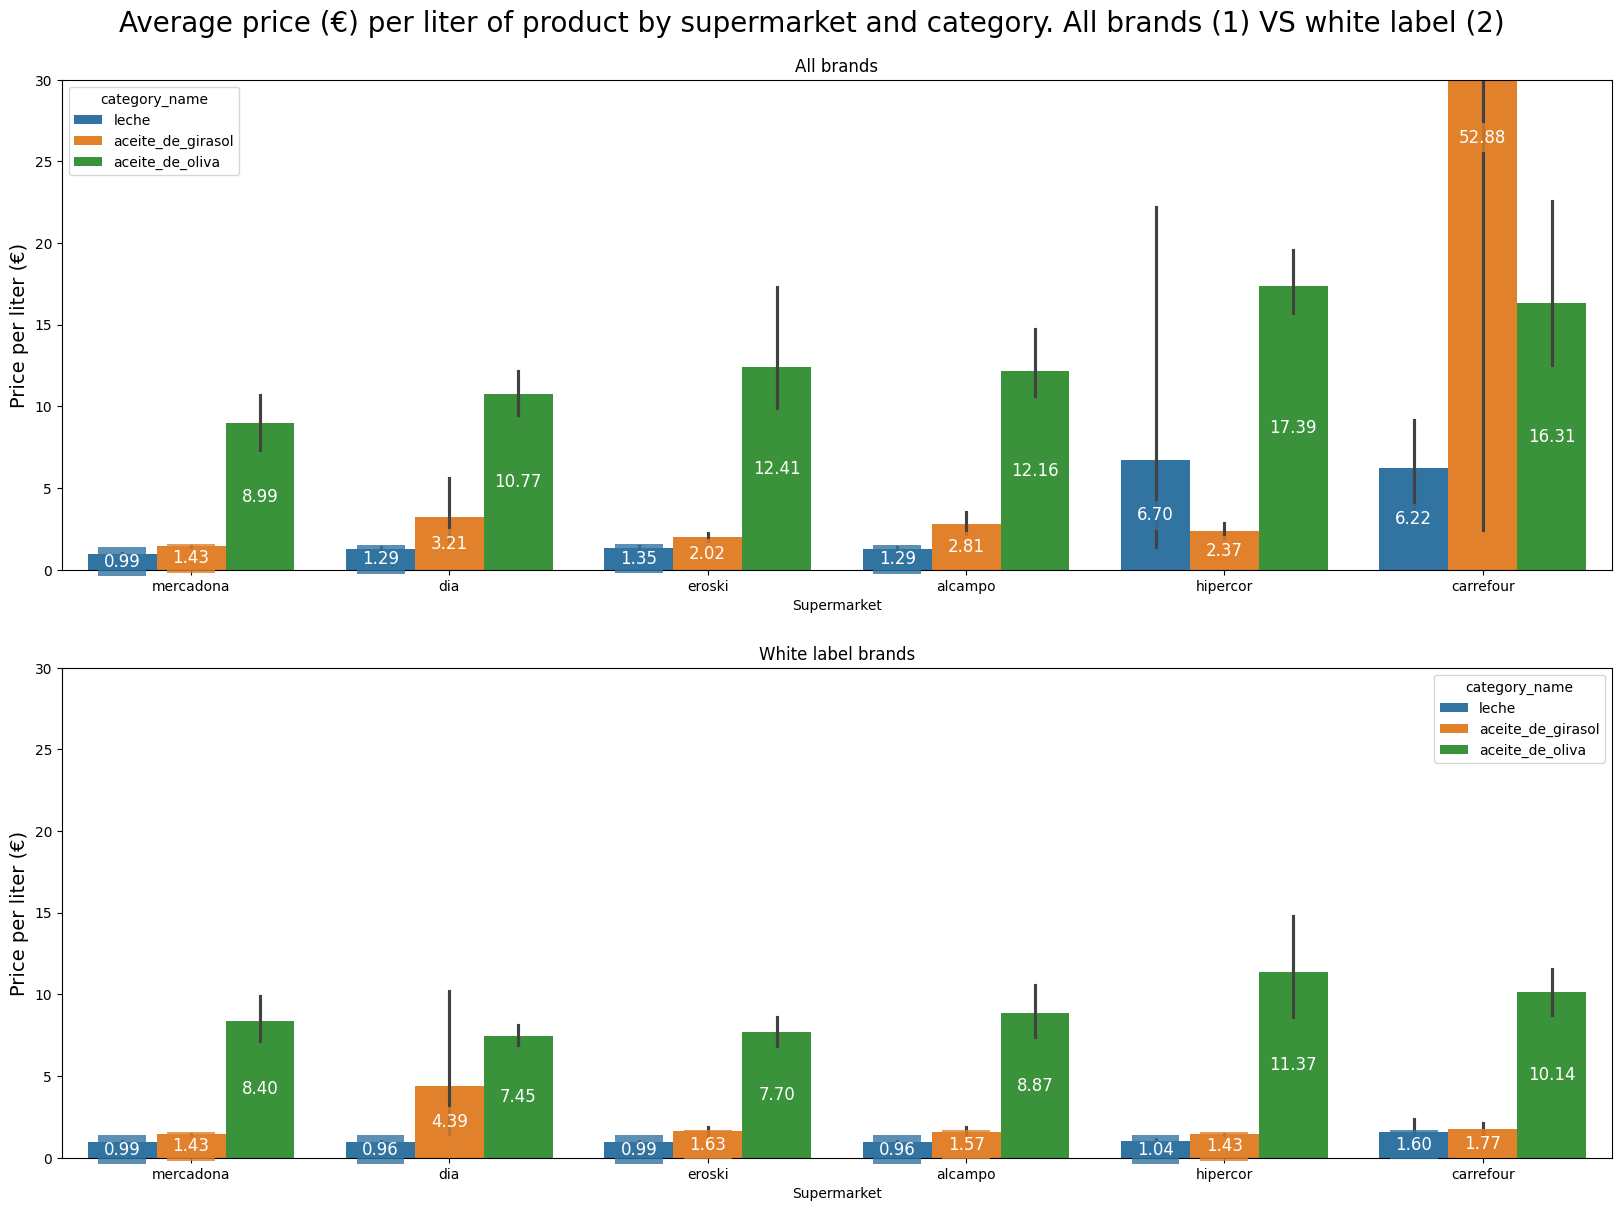

In [209]:
query = """
SELECT c.category_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, s2.supermarket_name,  COUNT(*) n_products
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
GROUP BY s2.supermarket_name, c.category_name, p.units
ORDER BY c.category_name, euro_per_liter;
"""

supermarket_average_category = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")

# query for all brands + white label
query1 = """
SELECT s2.supermarket_name, category_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
ORDER BY euro_per_liter;
"""
price_per_category_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query1, columns="query")

# query for white label only
query2 = """
SELECT s2.supermarket_name, category_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles')
ORDER BY euro_per_liter;
"""

price_per_category_white_label_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query2, columns="query")

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 14), sharey=True) 

plt.suptitle("Average price (€) per liter of product by supermarket and category. All brands (1) VS white label (2)", fontsize=20, y=0.93)

##First plot
sns.barplot(data=price_per_category_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             hue="category_name",
             ax=ax1,
             order=supermarket_average["supermarket_name"],
             estimator="mean")

# ax title
ax1.set_title("All brands")

# adding data labels
plot_bar_labels(ax1)

ax1.set_ylim(0,30)
ax1.set_ylabel("Price per liter (€)", fontsize=14)
ax1.set_xlabel("Supermarket")


## second plot
sns.barplot(data=price_per_category_white_label_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             hue="category_name",
             ax=ax2,
             order=supermarket_average["supermarket_name"],
             estimator="mean")

# ax title
ax2.set_title("White label brands")

# adding data labels
plot_bar_labels(ax2)


ax2.set_ylabel("Price per liter (€)", fontsize=14)
ax2.set_xlabel("Supermarket")


plt.show()

As stated previously, mercadona does not change greatly because it mainly sells it's white label brand. Dia's aceite the girasol on the other hand, seems to rise in price when focusing on its white label brand. That is something odd that will be worth looking into as next steps.

Overall, the whole picture for both sunflower oil and milk is very balanced, milk being cheapest on average at Dia sunflower oil having a tie on Hipercor and Mercadona. On the other hand, the cheapest olive oil is found at Dia.

### 2.2.1 Cheapest supermarket for products on average

To extract more clearly which supermarket are the cheapest for every product category, focusing on white label brands:

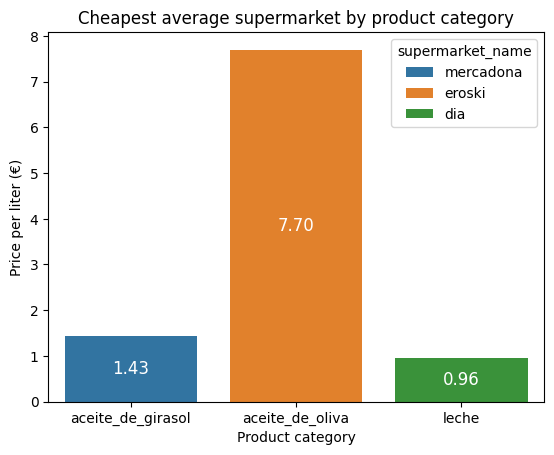

In [205]:
query = """WITH mean_price_per_unit AS (
SELECT s2.supermarket_name, c.category_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, 
		COUNT(*) n_products, ROW_NUMBER() OVER(PARTITION BY category_name ORDER BY SUM(sp.latest_price) / SUM(p.quantity * p.volume_weight) ASC)
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles')
AND sp.latest_price /(p.quantity * p.volume_weight) < 50
GROUP BY s2.supermarket_name, c.category_name,  p.units
ORDER BY category_name, euro_per_liter)

SELECT supermarket_name, category_name, euro_per_liter
FROM mean_price_per_unit
WHERE ROW_NUMBER = 1;"""

supermarket_cheapest_category = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")

fig, ax = plt.subplots()

plt.title("Cheapest average supermarket by product category")

sns.barplot(data=supermarket_cheapest_category,
             x="category_name",
             y="euro_per_liter",
             hue= "supermarket_name")


# adding data labels
plot_bar_labels(ax)

plt.xlabel("Product category")
plt.ylabel("Price per liter (€)")
plt.show()

As seen on the previous graph, for white label brands, buy:
- Sunflower seed oil at Mercadona
- Olive oil at Eroski
- Milk at Dia (Although also Alcampo is valid)

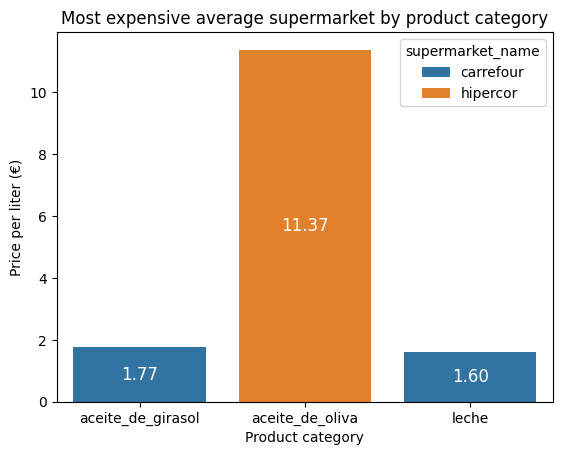

In [208]:
query = """WITH mean_price_per_unit AS (
SELECT s2.supermarket_name, c.category_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, 
		COUNT(*) n_products, ROW_NUMBER() OVER(PARTITION BY category_name ORDER BY SUM(sp.latest_price) / SUM(p.quantity * p.volume_weight) DESC)
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles')

GROUP BY s2.supermarket_name, c.category_name,  p.units
ORDER BY category_name, euro_per_liter)

SELECT supermarket_name, category_name, euro_per_liter
FROM mean_price_per_unit
WHERE ROW_NUMBER = 1;"""

supermarket_most_expensive_category = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")

fig, ax = plt.subplots()

plt.title("Most expensive average supermarket by product category")

sns.barplot(data=supermarket_most_expensive_category,
             x="category_name",
             y="euro_per_liter",
             hue= "supermarket_name")


# adding data labels
plot_bar_labels(ax)

plt.xlabel("Product category")
plt.ylabel("Price per liter (€)")
plt.show()

For the most expensive ones, for white label brands, there are:
- Sunflower seed oil at Carrefour
- Olive oil at Hipercor
- Milk at Carrefour again.

Below, a table with the cheapest products per categories and subcategories, and where to find them:

In [88]:
query = """WITH mean_price_per_unit AS (
SELECT  s2.supermarket_name, c.category_name, s.subcategory_name, s.distinction, quantity, volume_weight, p.units, ROUND((sp.latest_price) / (p.quantity * p.volume_weight),2) AS price_per_unit,  
		ROW_NUMBER() OVER(PARTITION BY c.category_name, s.subcategory_name, s.distinction ORDER BY (sp.latest_price) / (p.quantity * p.volume_weight) ASC) AS row_number
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b 
	ON p.brand_id = b.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'

ORDER BY category_name, s.subcategory_name, s.distinction, price_per_unit)

SELECT category_name, subcategory_name, distinction,supermarket_name,  quantity, volume_weight, price_per_unit
FROM mean_price_per_unit
WHERE row_number = 1;"""

where_to_buy_what = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")
where_to_buy_what


,category_name,subcategory_name,distinction,supermarket_name,quantity,volume_weight,price_per_unit
0,aceite_de_girasol,freir,,carrefour,1,5.0,1.35
1,aceite_de_girasol,normal,,alcampo,1,5.0,1.38
2,aceite_de_oliva,intenso,,mercadona,1,3.0,6.45
3,aceite_de_oliva,suave,,eroski,1,1.0,4.66
4,aceite_de_oliva,virgen,,dia,1,1.0,4.99
5,aceite_de_oliva,virgen extra,,hipercor,1,5.0,7.19
6,leche,cabra,,alcampo,1,1.0,23.43
7,leche,cabra,fresca,alcampo,1,0.75,4.52
8,leche,cabra,entera,hipercor,1,1.0,4.53
9,leche,cabra,entera fresca,hipercor,1,0.75,5.77


## 2.3 Price dependance on product format

Usually, the price of products displays a correlation with the size of their package, to explore this, the below graph shows the relation of price with respect to its package size, per category.

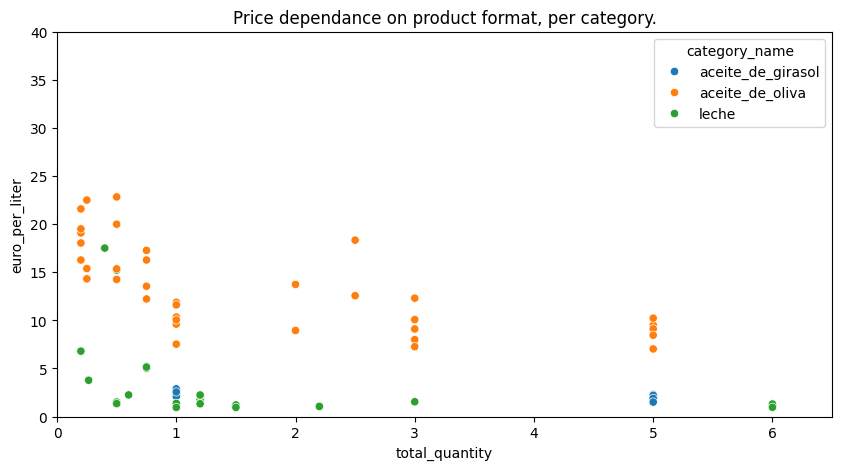

In [210]:

query = """SELECT s2.supermarket_name, c.category_name, p.quantity * p.volume_weight As total_quantity, p.units, SUM(sp.latest_price) / SUM(p.quantity * p.volume_weight) AS euro_per_liter, COUNT(*) n_products
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
GROUP BY s2.supermarket_name, c.category_name,p.quantity * p.volume_weight, p.units
HAVING COUNT(*) > 1
ORDER BY s2.supermarket_name, c.category_name,euro_per_liter;"""

format_size = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")

fig, ax = plt.subplots(figsize=(10,5))

plt.title("Price dependance on product format, per category.")


sns.scatterplot(
    data = format_size,
    x = "total_quantity",
    y = "euro_per_liter",
    hue="category_name",
    ax=ax
)


ax.set_ylim(0,40)
ax.set_xlim(0,6.5)
plt.show()

The above graph shows a clear inverse relationship between price per liter of product and its package size. There is a tendency to have a lower price per liter as the size of the package grows. This confirms the typical family size bargain for products where buying more is spending less, on one side thanks to packaging savings and on the other for quantity discount. 

The inverse is also true, where smaller, 'more convenient' packages are more expensive. This also happens to be the case for 'premium' quality products, where selling big quantities does not make that much sense.

## 2.4 Time evolution of prices

To properly display the evolution with time for products accross supermarkets and product category, it is necessary to split the graph in half, plotting 3 supermarkets at a time in the hue.

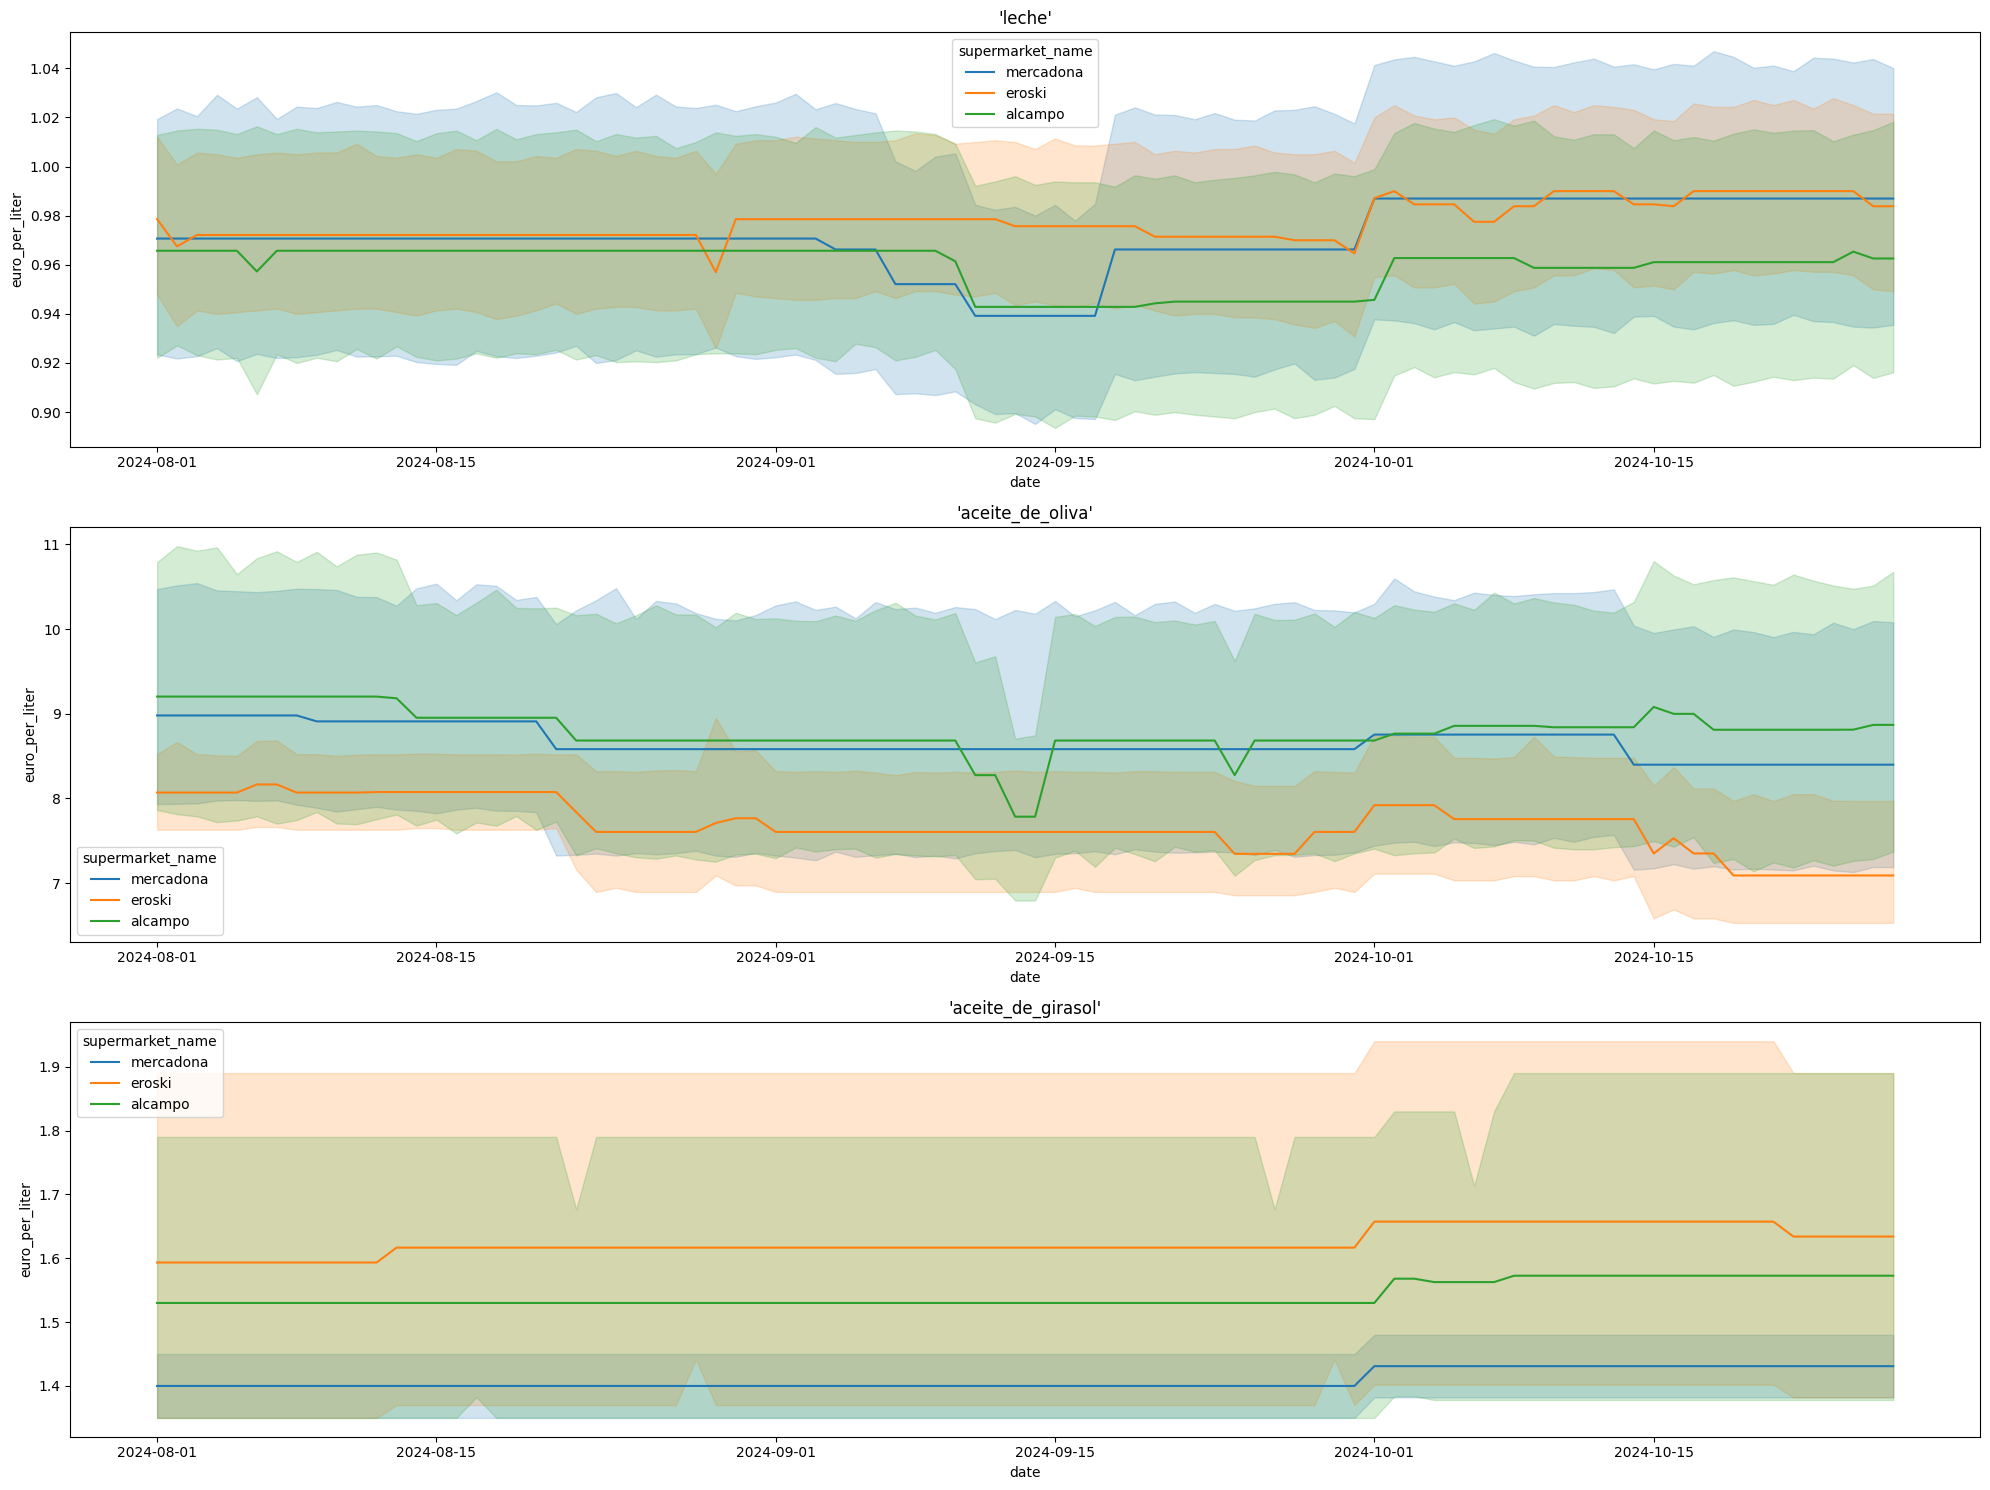

In [148]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

axes_flat = axes.flat

for ax, category in zip(axes_flat, ["'leche'", "'aceite_de_oliva'", "'aceite_de_girasol'"]):

    query = f"""
    SELECT s2.supermarket_name, category_name, date, 
            price_amount / (p.quantity * p.volume_weight) AS euro_per_liter
    FROM products p 
    INNER JOIN subcategories s 
        ON p.subcategory_id = s.subcategory_id 
    INNER JOIN categories c 
        ON s.category_id = c.category_id 
    INNER JOIN supermarkets_products sp 
        ON p.product_id = sp.product_id
    INNER JOIN supermarkets s2
        ON sp.supermarket_id = s2.supermarket_id 
    INNER JOIN brands b
        ON b.brand_id = p.brand_id 
    INNER JOIN prices p2
        ON sp.supermarket_product_id = p2.supermarket_product_id
    WHERE s.subcategory_name != 'otras'  
    AND units IS NOT NULL 
    AND units != 'g'
    AND s.subcategory_name NOT LIKE '%otras%'
    AND subcategory_name != 'cabra'
    AND category_name = {category}
    AND supermarket_name IN ('alcampo','eroski','mercadona')
    AND brand_name IN ('alcampo','eroski','hacendado')
    AND date >= '2024-08-01'
    ORDER BY sp.supermarket_product_id, date;
    """

    timeseries = connect_and_query("comparativa_supermercados", database_credentials, query)

	
    
    sns.lineplot(
        data=timeseries,
        x="date",
        y="euro_per_liter",
        hue="supermarket_name",
        ax=ax
    )
    ax.set_title(category)


plt.tight_layout()
plt.show()


The graphs above show:
- Milk. Ranging prices with a slight upward trend. Alcampo staying on the lower end.
- Olive oil. General downward trend, with Eroski staying on the lower end.
- Sunflower seed oil. General Slight upward trend.

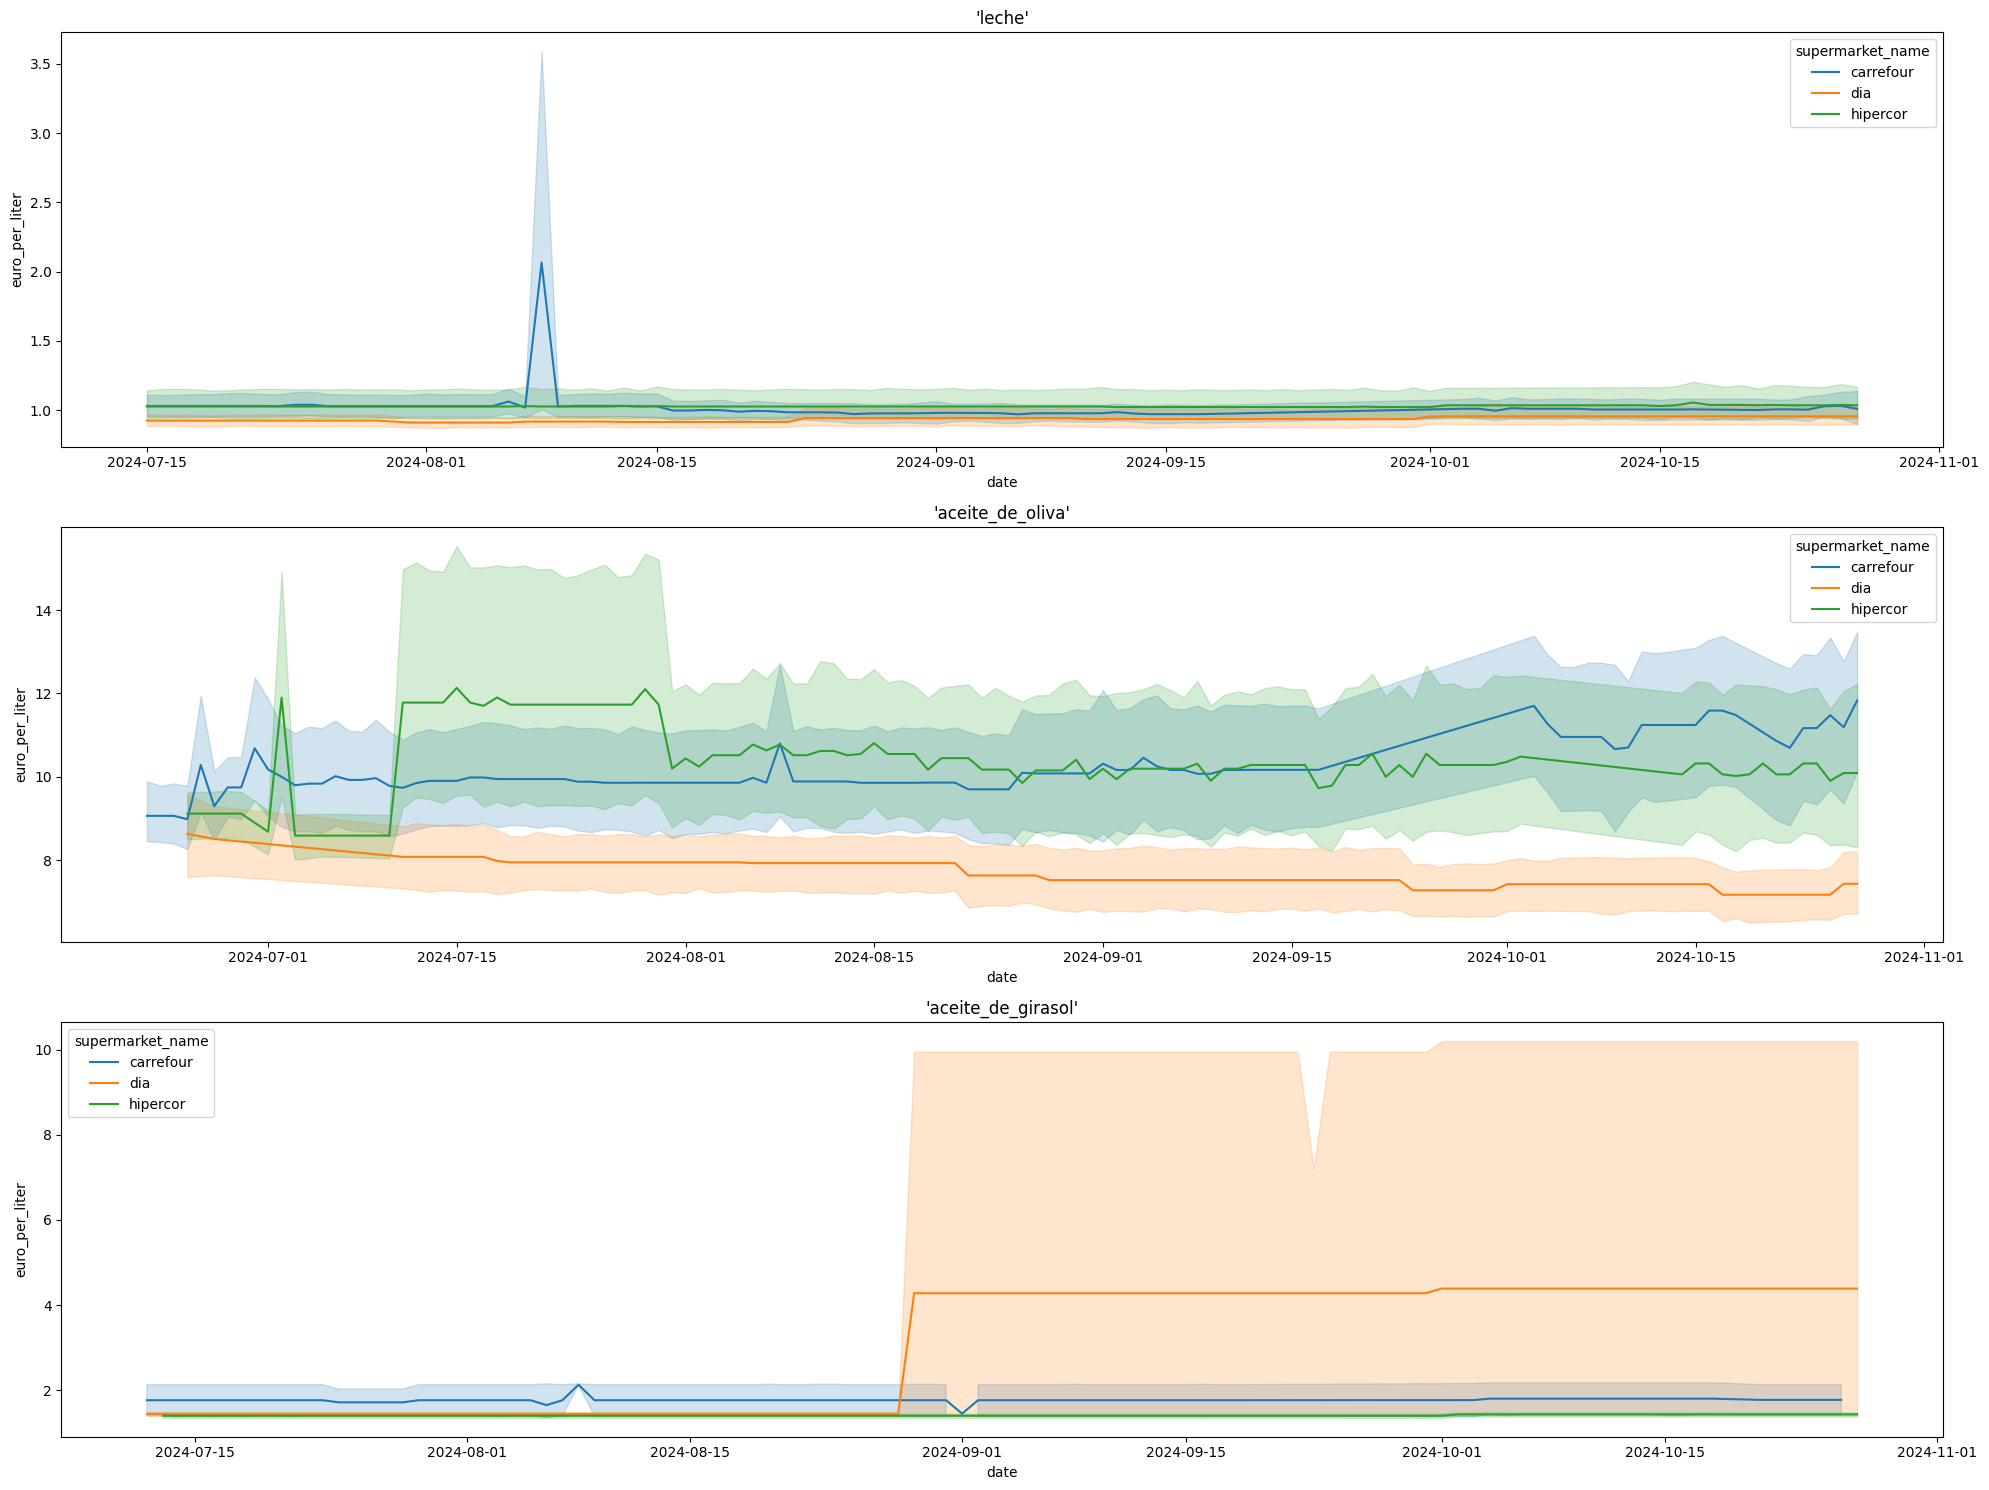

In [211]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

axes_flat = axes.flat

for ax, category in zip(axes_flat, ["'leche'", "'aceite_de_oliva'", "'aceite_de_girasol'"]):

    query = f"""
    SELECT s2.supermarket_name, sp.product_name_supermarket, category_name, subcategory_name, date, 
            price_amount / (p.quantity * p.volume_weight) AS euro_per_liter
    FROM products p 
    INNER JOIN subcategories s 
        ON p.subcategory_id = s.subcategory_id 
    INNER JOIN categories c 
        ON s.category_id = c.category_id 
    INNER JOIN supermarkets_products sp 
        ON p.product_id = sp.product_id
    INNER JOIN supermarkets s2
        ON sp.supermarket_id = s2.supermarket_id 
    INNER JOIN brands b
        ON b.brand_id = p.brand_id 
    INNER JOIN prices p2
        ON sp.supermarket_product_id = p2.supermarket_product_id
    WHERE s.subcategory_name != 'otras'  
    AND units IS NOT NULL 
    AND units != 'g'
    AND s.subcategory_name NOT LIKE '%otras%'
    AND subcategory_name != 'cabra'
    AND category_name = {category}
    AND supermarket_name IN ('dia','hipercor','carrefour')
    AND brand_name IN ('dia','el corte ingles','carrefour')
    ORDER BY sp.supermarket_product_id, date;
    """

    timeseries = connect_and_query("comparativa_supermercados", database_credentials, query)

	
    
    sns.lineplot(
        data=timeseries,
        x="date",
        y="euro_per_liter",
        hue="supermarket_name",
        ax=ax
    )
    ax.set_title(category)


plt.tight_layout()
plt.show()


The graphs above show a harder picture to examine, especially for milk and sunflower oil:
- Milk. Again, ranging prices, difficult to see the trend due to an important outlier spike in price around the first week of August for Carrefour.
- Olive oil. Dia has kept a downward trend from the beginning of July. Hipercor skyrocketted its price and then tried to normalise it, keeping it higher than at the beginning of July. Carrefour increased its price and almost 2 euros on average in little more than a month and a half.
- Sunflower seed oil. Difficult to see the trend, although seems to have a stable price saving two downward and upwards spkies for Carrefour, due to an important outlier spike in price around the last week of August for Dia. This weird outlier is what could be causing the higher average sunflower oil price that we saw on the barplots.

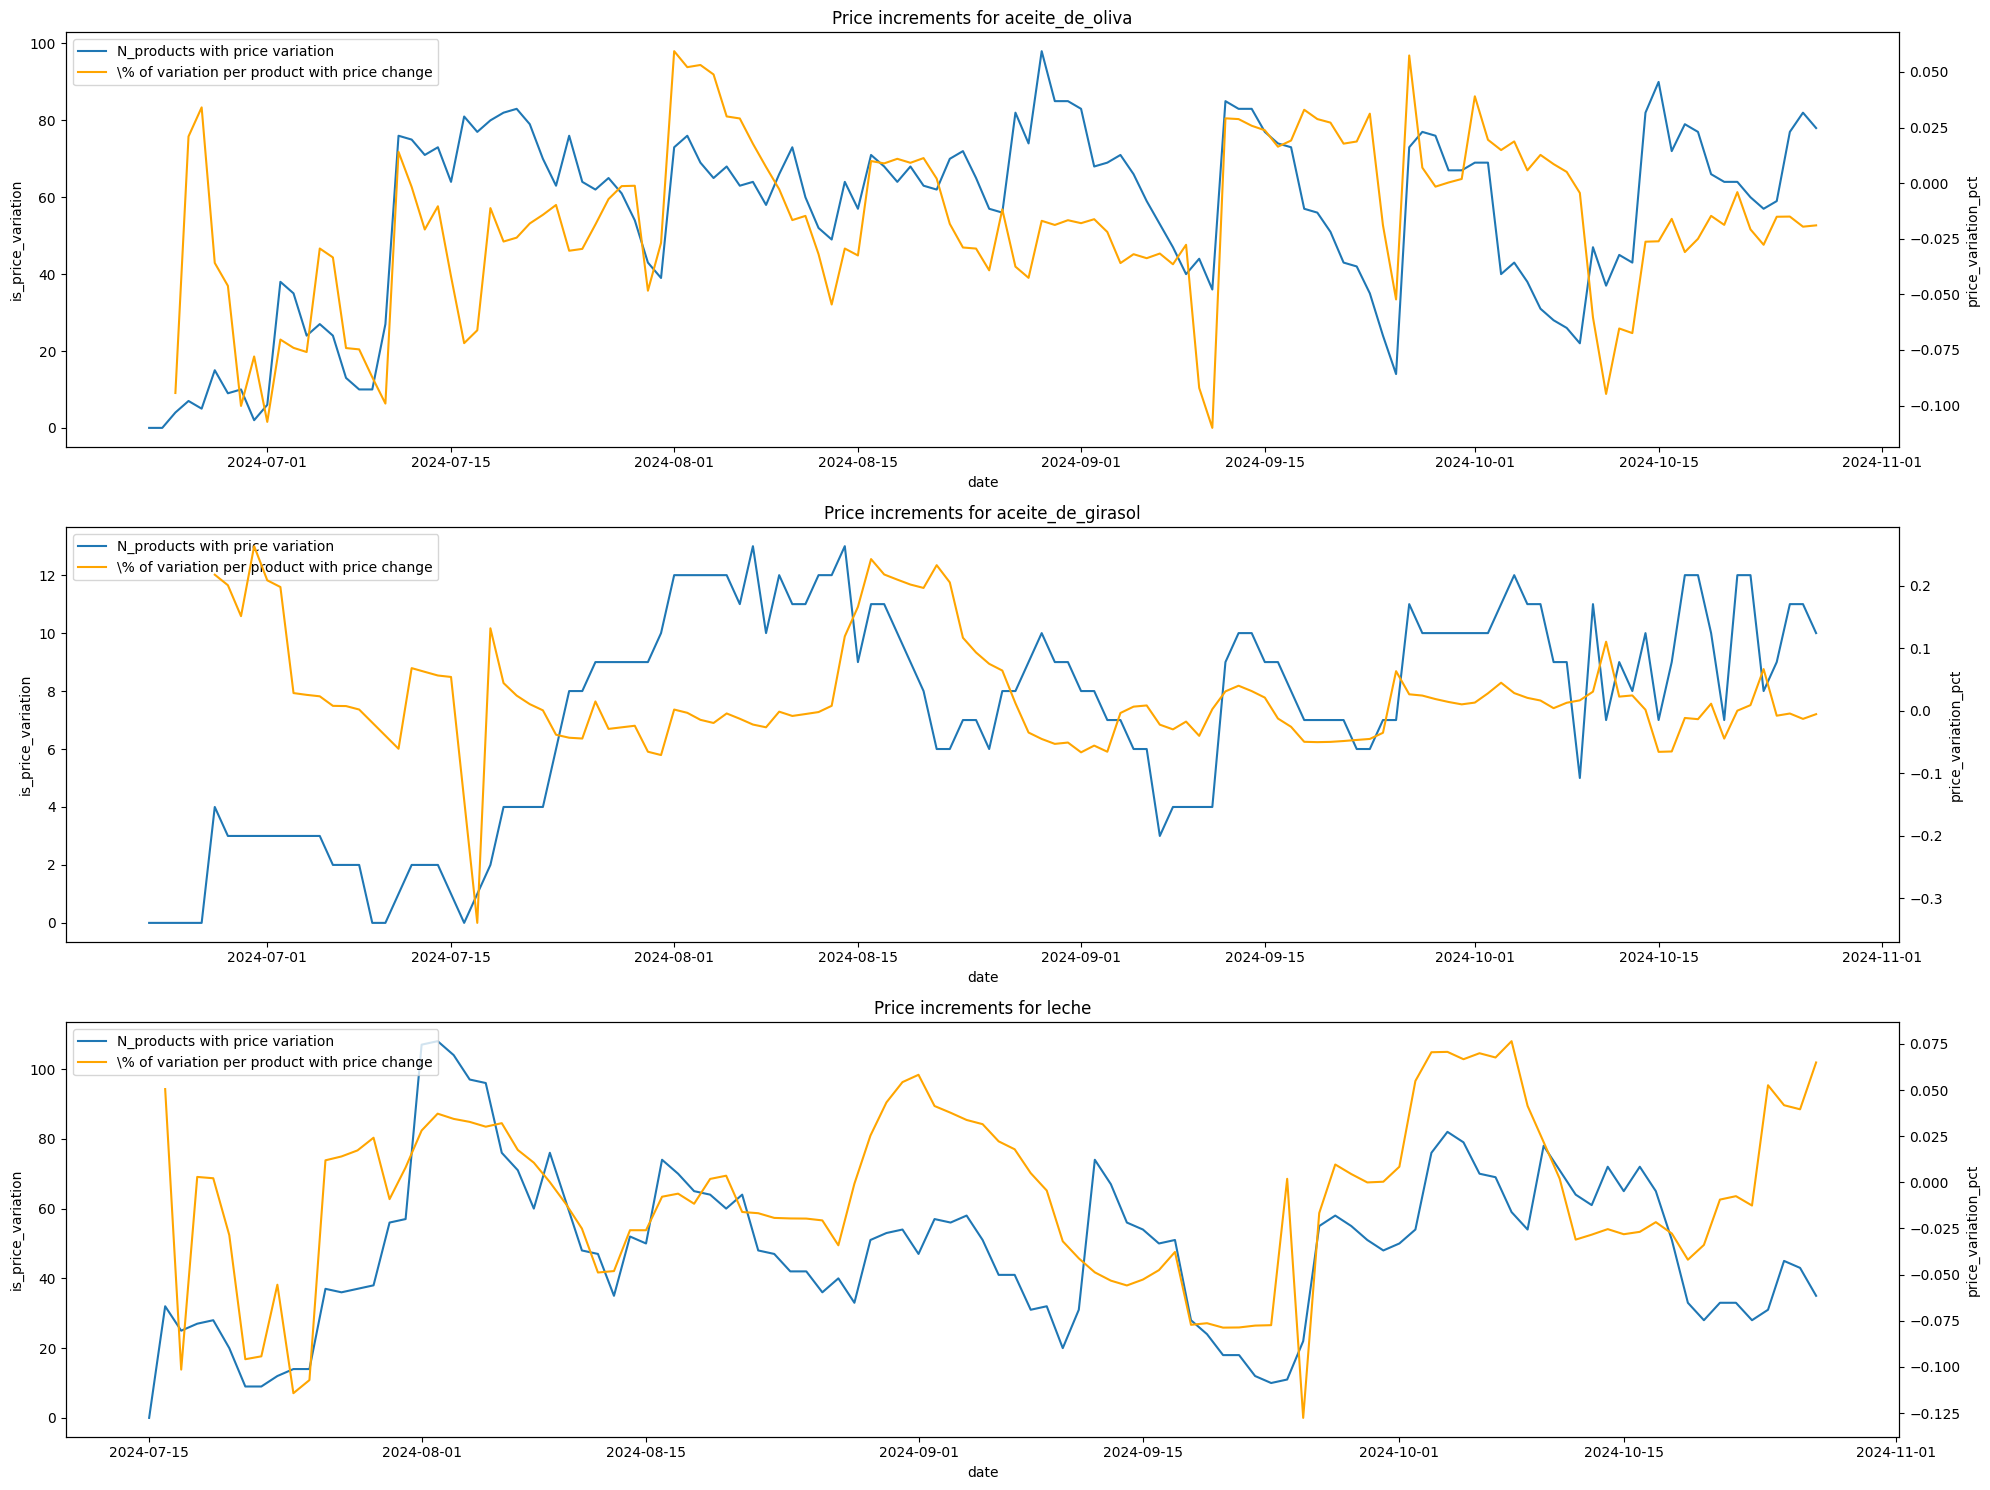

In [174]:
fig, axes = plt.subplots(3,1,figsize=(20, 15))

axes_flat = axes.flat 

for ax, category in zip(axes_flat, ["'aceite_de_oliva'","'aceite_de_girasol'","'leche'"]):
	query = f"""WITH moving_avg AS (
		SELECT date, price_amount / (p.quantity * p.volume_weight) AS eur_per_liter, AVG(price_amount / (p.quantity * p.volume_weight)) OVER(PARTITION BY sp.supermarket_product_id ORDER BY date ROWS BETWEEN 15 PRECEDING AND 1 PRECEDING) AS price_moving_avg,
				sp.supermarket_product_id, s2.supermarket_name, b.brand_name, c.category_name, s.subcategory_name
		FROM products p 
		INNER JOIN subcategories s 
			ON p.subcategory_id =s.subcategory_id 
		INNER JOIN categories c 
			ON s.category_id = c.category_id 
		INNER JOIN supermarkets_products sp 
			ON p.product_id = sp.product_id
		INNER JOIN supermarkets s2
			ON sp.supermarket_id = s2.supermarket_id 
		INNER JOIN brands b
			ON b.brand_id = p.brand_id 
		INNER JOIN prices p2
			ON sp.supermarket_product_id = p2.supermarket_product_id
		WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
		AND units IS NOT NULL 
		AND units != 'g'
		AND s.subcategory_name NOT LIKE '%otras%'
		AND subcategory_name != 'cabra'
		ORDER BY sp.supermarket_product_id, date)

	SELECT date, eur_per_liter, price_moving_avg, supermarket_product_id, supermarket_name,
			brand_name, category_name, subcategory_name,
			CASE WHEN (ABS((eur_per_liter - price_moving_avg)/price_moving_avg) > 0.05) THEN 1
			ELSE 0 END AS is_price_variation,
			CASE WHEN (ABS((eur_per_liter - price_moving_avg)/price_moving_avg) > 0.05) THEN (eur_per_liter - price_moving_avg)/price_moving_avg
			ELSE NULL END AS price_variation_pct
	FROM moving_avg
	WHERE category_name = {category};"""

	anomalies = connect_and_query("comparativa_supermercados", database_credentials, query)

	ax2 = ax.twinx()

	sns.lineplot(
		data=anomalies,
		x="date",
		y="is_price_variation",
		estimator="sum",
		ax=ax,
		errorbar=None,
		label="N_products with price variation"
	)

	sns.lineplot(
		data=anomalies,
		x="date",
		y="price_variation_pct",
		estimator="mean",
		color="orange",
		ax=ax2,
		errorbar=None,
		label="\% of variation per product with price change"
	)

	# combine ax and ax2 legends
	handles1, labels1 = ax.get_legend_handles_labels()
	handles2, labels2 = ax2.get_legend_handles_labels()
	ax.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc="upper left")

	# remove ax2 residue
	ax2.get_legend().remove()

	# set subplots titles
	category_formatted = category.replace('\'','')
	ax.set_title(f"Price increments for {category_formatted}")

plt.tight_layout()
plt.show()


# 3. Conclusions

- Carrefour and Hipercor show the most variability in their prices. Olive oil is the product that shows more spread in its prices, uncounting outliers in sunflower seed oil and milk.
- Mercadona focuses on developing its own white label brand. Keeping it the most affordable on average both for all brands and white label brands. Focusing on white label brands, Alcampo and Eroski keep up closely.
- The cheapest prices on average: Sunflower seed oil at Mercadona, Olive oil at Eroski and Milk at Dia (although also Alcampo is valid)
- There is a strong inverse correlation with package size and price per liter, where very small packages tend to be a lot more expensive.
- General evolution of Olive Oil price shows a downward trend, except for Hipercor and Carrefour, that have raised their prices by 2 euros on average. 
- Sunflower seed oil and milk show a slight upward trend in price.